In [1]:
%autoreload

from ase.io import read

from vibes.harmonic_analysis.force_constants import reshape_force_constants
from vibes.helpers.lattice import fractional
from vibes.helpers.lattice_points import get_lattice_points, map_I_to_iL
from vibes.io import parse_force_constants
from vibes.harmonic_analysis.dynamical_matrix import get_frequencies
from vibes.helpers.brillouinzone import get_bands_and_labels

In [2]:
atoms = read("geometry.in.primitive", format="aims")

primitive = read("geometry.in.primitive", format="aims")
supercell = read("geometry.in.supercell", format="aims")

fc = parse_force_constants(
    "FORCE_CONSTANTS",
    primitive=primitive,
    supercell=supercell,
    two_dim=False,
    symmetrize=True,
)

In [3]:
bands, labels = get_bands_and_labels(primitive, npoints=50)
path = bands[0]
labels

['G', 'X', 'U|K', 'G', 'L']

In [4]:
lps, elps = get_lattice_points(primitive.cell, supercell.cell)

[mode]         .. found 32 (31) lattice points in 0.001s


In [5]:
I_to_iL = map_I_to_iL(primitive, supercell, lattice_points=lps)

[mode]         .. matched 96 positions in supercell and primitive cell in 0.237s


In [6]:
for (lp, elp) in zip(lps, elps):
    print((lp))
    print(len(elp))

[0. 0. 0.]
1
[ 0.        -2.5356776 -2.5356776]
1
[ 2.5356776  0.        -2.5356776]
1
[-2.5356776  0.        -2.5356776]
1
[ 2.5356776 -2.5356776  0.       ]
1
[-2.5356776 -2.5356776  0.       ]
1
[ 0.         2.5356776 -2.5356776]
1
[ 0.        -2.5356776  2.5356776]
1
[2.5356776 2.5356776 0.       ]
1
[-2.5356776  2.5356776  0.       ]
1
[2.5356776 0.        2.5356776]
1
[-2.5356776  0.         2.5356776]
1
[0.        2.5356776 2.5356776]
1
[ 0.          0.         -5.07135519]
2
[ 0.         -5.07135519  0.        ]
2
[-5.07135519  0.          0.        ]
2
[ 2.5356776  -2.5356776  -5.07135519]
2
[-2.5356776  -2.5356776  -5.07135519]
2
[ 2.5356776  -5.07135519 -2.5356776 ]
2
[-2.5356776  -5.07135519 -2.5356776 ]
2
[ 2.5356776   2.5356776  -5.07135519]
2
[-2.5356776   2.5356776  -5.07135519]
2
[-5.07135519 -2.5356776  -2.5356776 ]
2
[-5.07135519  2.5356776  -2.5356776 ]
2
[ 2.5356776  -5.07135519  2.5356776 ]
2
[-2.5356776  -5.07135519  2.5356776 ]
2
[-5.07135519 -2.5356776   2.5356

In [7]:
def _prefactor(q, r):
    r"""Get the prefactor `exp(-2*\pi*i * q @ r)`"""
    phase = -2.0j * np.pi * q @ r
    # print(phase / np.pi)
    return np.exp(phase)


def get_dynamical_matrices(q_points, primitive, supercell, force_constants, tol=1e-9):
    """build the dynamical matrix for each q_point

    Parameters
    ----------
    q_points: list of np.ndarray
        The list of q-points to build they dynamical matrix at
    primitive: ase.atoms.Atoms
        The primitive cell structure
    supercell: ase.atoms.Atoms
        The supecell structure
    force_constants: np.ndarray
        The force constant matrix
    eps: float
        computer tolerance

    Returns
    -------
    list of np.ndarray
        They dynamical matrix at each point in q_points
    """

    lattice_points, extended_lattice_points = get_lattice_points(
        primitive.cell, supercell.cell
    )

    sc_center = 0.5 * supercell.cell.sum(axis=0)

    force_constants_reshaped = reshape_force_constants(
        primitive,
        supercell,
        force_constants,
        lattice_points=lattice_points,
        scale_mass=True,
        symmetrize=False,
    )

    n_prim = len(primitive)

    ppos = primitive.positions

    dyn_matrices = []

    for qq in q_points:
        dyn_matrix = np.zeros([n_prim, n_prim, 3, 3], dtype=complex)

        for LL, shell in enumerate(extended_lattice_points):
            weight = len(shell)

            for _, lp in enumerate(shell):

                for ii in range(n_prim):
                    for jj in range(n_prim):

                        # is r_j + R_L - r_i in extended supercell i.e. [-0.5, 0.5]?
                        r_ij = -ppos[ii] + ppos[jj]
                        R_ij_frac = fractional(r_ij + lp, supercell.cell)

                        # effectively map atom into supercell
                        R = R_ij_frac
                        d =  0.5 - np.sign(R) * tol
                        lp_temp = lp - supercell.cell @ (R - ((R + d) % 1 - d))

                        q_frac = primitive.cell.reciprocal().T @ qq
                        prefactor = _prefactor(q_frac, lp_temp) / weight
                        dyn_matrix[ii, jj, :, :] += (
                            prefactor * force_constants_reshaped[ii, 0, jj, LL]
                        )

        # check hermiticity
        d_ij = dyn_matrix.swapaxes(1, 2).reshape(3 * n_prim, 3 * n_prim)

        d_ij = 0.5 * (d_ij + d_ij.T.conj())

        diff = np.linalg.norm(d_ij - d_ij.conj().T)
        assert diff < 1e-12, (diff, d_ij)

        dyn_matrices.append(d_ij)

    return np.array(dyn_matrices)

In [8]:
kw = {'primitive': primitive, 'supercell': supercell, 'force_constants': fc}
dynmats = get_dynamical_matrices(path, **kw)

[mode]         .. found 32 (31) lattice points in 0.002s
[phonopy.utils] remap force constants
[phonopy.utils] .. use fortran
[phonopy.utils] .. time elapsed: 0.110s
** Warning from file vibes/phonopy/utils.py, line 361, function remap_force_constants:
--> Force constants are not symmetric by 7.84e-01.

** Warning from file vibes/phonopy/utils.py, line 370, function remap_force_constants:
--> Sum rule violated by 3.23e-02 (axis 1).

[mode]         .. matched 96 positions in supercell and primitive cell in 0.245s


In [9]:
x = []
band = np.zeros((len(path), len(primitive) ** 2))

for ii, q in enumerate(zip(path)):
    x.append(np.linalg.norm(q) / np.pi)

    D = dynmats[ii]
    freqs = get_frequencies(D)
    band[ii] = freqs

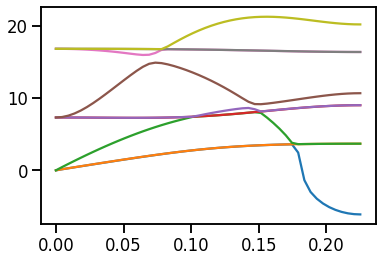

In [10]:
for ii in range(band.shape[1]):
    plt.plot(x, band[:, ii])